# PA2
## Members: Xiwen Chen, Yifei Zhang, Ai Zhang, Zhuoxuan Deng

### Three classes:
- `Repo(owner,reponame)`
- `User(login,NumOfPullReq)`
- `PullRequest(owner,reponame,number)`




### Functions

- `ListAllRepos()`
- `owner,reponame=ChooseOwnerRepo()`
- `listAllPullRequests()`
- `SummaryARepo()`
- `GraphicsARepo(owner,reponame)`
- `GraphicsAllRepos()`
- `CorrUsersDatas()`
- `CorrARepo(owner,reponame)`






#### MORE:
- Can override the old version of collected data from a repo (owner-repo.csv)
- Can update the latest users info based on the latest collection (user.csv)
- Good to process low information repo/user (e.g. No follw  info, no any pull request, e.g)

### Import modules

In [1]:
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import unittest
from datetime import date
import os
import numpy as np

### Create subfolder repos

In [2]:
if os.path.exists('./repos/') == False:
    os.makedirs('./repos/')

### Set Username and token from github

In [3]:
username = 'XiwenChen-NAU'
token    = '6e32fc502986b503e29e44520235e3f2526694c5'

In [4]:
import os
from collections import Counter
class Repo:
    def __init__(self,owner,reponame):
        url      = "https://api.github.com/repos/"+str(owner) + "/" + str(reponame)
        API      = requests.get(url, auth=(username,token))
        if API.status_code != 200:
            print('\033[91m'+"**Repo Collection failed. Check the owner and repo name**\n")
            return 
        else:
            data = API.json()
            self.date_of_collection = str(date.today())
            self.name = str(data["name"])
            self.description = str(data["description"])
            self.owner = str(data["owner"]["login"])
            self.homepage = str(data["homepage"])
            self.license = str(data["license"]).replace(",","|")
            self.forks = str(data["forks"])
            self.watchers = str(data["watchers"]) ##watchers = starring: https://developer.github.com/changes/2012-09-05-watcher-api/
            self.stars = str(data["stargazers_count"])
            self.PullRequests = [] #Store PullRequest object
            self.UsersInfo = [] #Store Users object
            self.Logins = []  #Store all logins.
            self.GetPullInfo()
            self.GetUserInfo()
            self.to_CSV()
            
            

    def to_CSV(self):
        Filename = "./repos.csv"
        Header = "date_of_collection,"  + "name," + "owner,"+ "description," + "homepage," + "forks," + "watchers," + "license\n"
        Row    = ','.join([self.date_of_collection, self.name, self.owner, self.description,self.homepage, self.forks, self.watchers,self.license])+"\n"
        if os.path.exists(Filename) == True :
            f = open(Filename, "a+")
            f.writelines(Row)
            f.close()
        else:
            f = open(Filename, "a+")
            f.writelines(Header)
            f.writelines(Row)
            f.close()
        print("This repo is collected to .csv file")
            
    def __str__(self):
        return self.owner + "/" + self.name + ": " + self.description + "(" + self.stars + " stars)"
    def GetPullInfo(self):
        url = "https://api.github.com/search/issues?q=is:pr+repo:"+ self.owner + "/" + self.name
        DATA = requests.get(url, auth=(username,token)).json()
        Items = DATA["items"]
        ## Override the old version of collected repo/ for no pullrequet repo 
        Filename = "./repos/"+ self.owner + "-" + self.name + ".csv"
        f = open(Filename, "w+")  
        Header = "title," + "number,"  +"state," + "date_of_creation," + "closing_date,"+ "user," + "commits," + "additions," + "deletions,"+ "changed_files,"+"body\n"
        f.writelines(Header)
        f.close()
        
        for Item in Items:
            self.PullRequests.append(PullRequest(self.owner, self.name, Item["number"]))
            #PullRequest(self.owner, self.name, Item["number"]).to_CSV
            
    def GetUserInfo(self):
        url = "https://api.github.com/search/issues?q=is:pr+repo:"+ self.owner + "/" + self.name
        DATA = requests.get(url, auth=(username,token)).json()
        Items = DATA["items"]
        for Item in Items:   
            self.Logins.append(Item["user"]["login"])
            #Item["user"]["login"]
        CountPulls = dict(Counter(self.Logins)) #return a dict
        Users = CountPulls.keys()
        self.NumOfUsers = len(Users)   
        
        for L in Users:
            self.UsersInfo.append(User(L,CountPulls[L]))  ## Override the old version of users in class users
        #User(L,CountPulls[L]).to_CSV

    
    def SummaryRepo(self):
        StateOpen = 0
        stateClosed = 0
        
        for Pull in self.PullRequests:
            if Pull.state == 'open':
                StateOpen = StateOpen+1
            else:
                stateClosed = stateClosed+1
        
        NumOfUsers = self.NumOfUsers
        if len(self.PullRequests)!=0:
           
            OldsetPullDate = self.PullRequests[-1].date_of_creation
        else:
            OldsetPullDate ='None'
        
        print( "number of pull requests in open state: %d\n \
                number of pull requests in closed state: %d\n \
                number of users: %d\n \
                date of the oldest pull requested: %s\n"\
              %(StateOpen, stateClosed, NumOfUsers,OldsetPullDate))
        
        
        
            
        

In [5]:
class User:
    def __init__(self,login,NumOfPullReq):
        
        self.login = login
        self.NumOfPullReq = str(NumOfPullReq)
        url = "https://github.com/" + login
        Page = requests.get(url)
        if Page.status_code !=200:  # If author is a bot
            self.NumOfRepos = 0
            self.NumOfFllowers = 0
            self.NumOfFllowing = 0
            self.Contributions = 0
        else:

            PageContent=Page.content
            Soup = BeautifulSoup(PageContent, "html.parser")

            SoupData_0 = Soup.find_all("span", "Counter")
            self.NumOfRepos = SoupData_0[0].get_text().strip()

            SoupData_1 = Soup.find_all("span", "text-bold text-gray-dark")
            if len(SoupData_1) == 0: ## Info of some users unavailable (e.g. https://github.com/EfayZ)
                self.NumOfFllowers = 0
                self.NumOfFllowing = 0

            else:
                self.NumOfFllowers = SoupData_1[0].get_text().strip().replace(",","")
                self.NumOfFllowing = SoupData_1[1].get_text().strip().replace(",","")

            SoupData_2 = Soup.find_all("h2","f4 text-normal mb-2")
            self.Contributions =  SoupData_2[0].get_text().strip().split()[0].replace(",","")
            
            self.to_CSV()
    
    def to_CSV(self):
        Filename = "./users.csv"
        Header = "login," + "#PullReq,"  + "#repo," + "#followers," + "#following," + "#contributions\n"
        
        Row =','.join([str(self.login),str(self.NumOfPullReq),str(self.NumOfRepos),str(self.NumOfFllowers),str(self.NumOfFllowing),str(self.Contributions)])+"\n"
       
        if os.path.exists(Filename) == True:
            f = open(Filename, "a+")
            f.writelines(Row)
            f.close()
        else:
            f = open(Filename, "a+")
            f.writelines(Header)
            f.writelines(Row)
            f.close()
            
        ## Users overide
        UserDF = pd.read_csv(Filename)
        index = UserDF[UserDF["login"]==self.login].index.to_list()
        UserDF=UserDF.drop(index[:-1]) ##keep the latest one
        UserDF.index = range(len(UserDF))
        UserDF.to_csv("./users.csv",index=False)
            
                
            
        
        
        

        

In [6]:
class PullRequest:
    def __init__(self,owner,reponame,number):
        url = "https://api.github.com/repos/" + str(owner) + "/" + str(reponame)+"/pulls/" + str(number)
        DATA = requests.get(url, auth=(username,token)).json()
        self.owner = owner
        self.name = reponame
        self.title = str(DATA["title"])
        self.number = str(DATA["number"])
        self.body = str(DATA["body"])
        self.state = str(DATA["state"])
        self.date_of_creation = str(DATA["created_at"])
        if  self.state == 'closed':
            self.closing_date = str(DATA["closed_at"])
        else:
            self.closing_date ="None"
        self.user = str(DATA["user"]["login"])
        self.commits = str(DATA["commits"])
        self.additions = str(DATA["additions"])
        self.deletions =str(DATA["deletions"])
        self.changed_files = str(DATA["changed_files"])
        self.to_CSV()
    def __str__(self):
        print(str(self.number) + ": " + str(self.title))
        
    def to_CSV(self):
        Filename = "./repos/"+ self.owner + "-" + self.name + ".csv"
        #Header = "title," + "number,"  +"state," + "date_of_creation," + "closing_date,"+ "user," + "commits," + "additions," + "deletions,"+ "changed_files,"+"body\n"
        Row  = ','.join([self.title,self.number,self.state,self.date_of_creation,self.closing_date,self.user,self.commits,self.additions,self.deletions,self.changed_files,self.body])+"\n"
        f = open(Filename, "a+")
        f.writelines(Row)
        f.close()
        #if os.path.exists(Filename) == True:
        #    f = open(Filename, "a+")
        #    f.writelines(Row)
        #    f.close()
        #else:
        #    f = open(Filename, "a+")
        #    f.writelines(Header)
        #    f.writelines(Row)
        #    f.close()
        #print("This repo is collected to .csv file")

    

In [7]:
def ListAllRepos():
    if os.path.exists("repos.csv") == False:
        print("**no repo collected!**\n")
        return
    AllRepos = pd.read_csv("repos.csv")
    display(AllRepos)
    

In [8]:
def ChooseOwnerRepo():
    if os.path.exists("repos.csv") == False:
        print("**no repo collected!**\n")
        return False,False
    AllReposName = pd.read_csv("repos.csv",usecols = ["owner", "name"])
    print(AllReposName)
    while 1:
        try:
            print("**If a repo has multiple collections, You can only operate the most current collected repo**\n")
            Index = int(input("please input the index of the repo:"))
            if Index <0 or Index > len(AllReposName):
                raise ValueError
                
        except ValueError:
            print("**Please input correct index**")
        else:
            break
    SelectRepo = AllReposName.loc[Index]
    owner=SelectRepo["owner"] 
    reponame = SelectRepo["name"]
    return owner,reponame

In [9]:
def listAllPullRequests():
    if os.path.exists("repos.csv") == False:
        print("**no repo collected!**\n")
        return False
    AllReposName = pd.read_csv("repos.csv",usecols = ["owner", "name"])
    print(AllReposName)
    while 1:
        try:
            Index = int(input("please input the index of the repo:"))
            if Index <0 or Index > len(AllReposName):
                raise ValueError
                
        except ValueError:
            print("**Please input correct index**")
        else:
            break
    SelectRepo = AllReposName.loc[Index]
    Fliename =   "./repos/" + SelectRepo["owner"] + "-" + SelectRepo["name"] + ".csv"
    Pulls    = pd.read_csv(Fliename)
    
    return Pulls
    
            
        
    
    

In [10]:
def SummaryARepo():
    DF=listAllPullRequests()  
    if type(DF)!=pd.core.frame.DataFrame: #no repo collected
        StateOpen = 0
        stateClosed = 0
        OldsetPullDate ='None'
        NumOfUsers=0
        
    elif len(DF)==0:  # some repo no any information
        StateOpen = 0
        stateClosed = 0
        OldsetPullDate ='None'
        NumOfUsers=0
    else:
        StateOpen = len(DF[DF["state"]=='open'])
        stateClosed = len(DF[DF["state"]=='closed'])
        NumOfUsers = len(DF["user"].unique())       
        OldsetPullDate = DF["date_of_creation"].to_list()[-1]

    print( "number of pull requests in open state: %d\n \
            number of pull requests in closed state: %d\n \
            number of users: %d\n \
            date of the oldest pull requested: %s\n"\
          %(StateOpen, stateClosed, NumOfUsers,OldsetPullDate))

In [11]:
import seaborn as sns
def GraphicsARepo(owner,reponame):
    Filename = "./repos/"+ owner + "-" + reponame + ".csv"
    
    if os.path.exists(Filename) == False:
        print("**The repo is not existed**\n")
        return
    DF = pd.read_csv(Filename)
    if len(DF)==0:
        print("**No any pull request for current repo**\n")
        return
    DF["commits"] = pd.to_numeric(DF["commits"])
    DF["additions"] = pd.to_numeric(DF["additions"])
    DF["deletions"] = pd.to_numeric(DF["deletions"])
    DF["changed_files"] = pd.to_numeric(DF["changed_files"])
    # First plot
    sns.boxplot(x="state", y="commits", data=DF)
    plt.title("open and closed pull requests per commits")
    plt.show()
    # Second plot
    plt.subplot(1,2,1)
    sns.boxplot(x="state",y="additions", data=DF)
    plt.subplot(1,2,2)
    sns.boxplot(x="state",y="deletions", data=DF)
    #plt.tight_layout()
    plt.suptitle("open and closed pull requests per additions/deletions")
    plt.subplots_adjust(wspace=0.4,hspace=0.15)
    plt.show()
    # Third plot
    DFbyUser = DF.groupby(["user"]).sum()
    sns.boxplot(y="changed_files",data=DFbyUser)
    plt.title("The Number of Changed Files Grouped by the Author Association")
    plt.show()
    
    
    #Scatterplot: Additions vs Deletions
    sns.scatterplot(x="additions", y="deletions", data=DF)
    plt.title("Scatterplot: Additions vs Deletions")
    plt.show()
    
    # Hist
    #sns.histplot( x="commits",data=DF) versino problem. 
    DF['commits'].plot.hist()
    plt.title("Histogram: Number of Commits per Pull Request")
    plt.show()
    

In [12]:
def GraphicsAllRepos():
    Path = "./repos"
    Files= os.listdir(Path) 
    DF = pd.DataFrame([],columns=["title" ,"number" , "state",  "date_of_creation" , "closing_date", "user" ,"commits" ,"additions" , "deletions","changed_files","body"])
    UsersPerRepo = []
    FileNames = []
    for File in Files:
        if not os.path.isdir(File):
            FileNames.append(File)
            df = pd.read_csv(Path+"/"+File)
            UsersPerRepo.append(len(df["user"].unique())) 
            DF=pd.concat([DF,df])
                
    if len(DF) == 0:
        return
    #DF["commits"] = pd.to_numeric(DF["commits"])
    DF["additions"] = pd.to_numeric(DF["additions"])
    DF["deletions"] = pd.to_numeric(DF["deletions"])
    DF["changed_files"] = pd.to_numeric(DF["changed_files"])
    DF["date_of_creation"]=DF["date_of_creation"].str.split('T',expand=True)
    DF["pull"] = np.ones(len(DF))
    DFbyDay = DF.groupby(["date_of_creation"]).sum()
    
    
    
    
    # Pull request per day
    sns.lineplot(x =DFbyDay.index,y="pull",data =  DFbyDay)
    plt.xticks(rotation = 'vertical')
    plt.xlabel("Time")
    plt.ylabel("The number of pull request")
    plt.title("The number of open pull requests per day")
    plt.show()
    
    #
    DFbyDayOpen = DF[DF["state"]=="open"].groupby(["date_of_creation"]).sum()
    DFbyDayCloses = DF[DF["state"]=="closed"].groupby(["date_of_creation"]).sum()
    plt.plot(DFbyDayOpen.index,DFbyDayOpen["pull"])
    plt.plot(DFbyDayCloses.index,DFbyDayCloses["pull"])
    plt.legend(["Open","Closed"])
    plt.xticks(rotation = 'vertical')
    plt.xlabel("Time")
    plt.title("number of open and closed pull requests per day")
    plt.show()
    
    # User
    plt.bar(x=FileNames, height=UsersPerRepo)
    plt.xlabel("Repo")
    plt.ylabel("The Number of Users")
    plt.title("the number of users per repo")
    plt.xticks(rotation = -45)
    plt.show()
    
    
    


In [13]:
def CorrUsersDatas():
    Filename = "users.csv"
    if os.path.exists(Filename) == False:
        print("**The users information is not available**")
        return
    DF = pd.read_csv(Filename)    
    display(DF.corr()) #exclude NA/str/null

In [14]:
def CorrARepo(owner,reponame):
    Filename = "./repos/"+ owner + "-" + reponame + ".csv"
    
    if os.path.exists(Filename) == False:
        print("**The repo is not existed**\n")
        return
    DF = pd.read_csv(Filename)
    if len(DF)==0:
         print("**No any pull request for current repo**\n")
            
    display(DF.corr())   #Some case is nan, because e.g. Var(change_file)=0

## Main Function

In [15]:
def main():
    while 1:
        Option = input("Please Input Your option 1-9:\n\
        1: Collect data from a specific repo.\n\
        2: list all pull requests from a repo.\n\
        3: list the summary of a repo\n\
        4: Graphical summary of a repo\n\
        5: Correlation between the data from a repo \n\
        6: List all collected repos \n\
        7: Correlation between the data from users \n\
        8: Graphical summary of pull requests from all repos\n\
        9: Exit exit.\n\
        Your Input is:")
        try:
            Option = int(Option)
            if Option<1 or Option>9:
                raise ValueError
        except ValueError:
            print("**Please input 1-9**\n")
        
        if Option == 1:
            owner = input("input the repo owner name:")
            reponame = input("input the repo name:")
            Repo(owner,reponame)
            
        elif Option == 2:
            df=listAllPullRequests()
            display(df)
        elif Option == 3:
            SummaryARepo()
        elif Option == 4:      
            owner,reponame=ChooseOwnerRepo()
            if owner != False:
                GraphicsARepo(owner,reponame)
        elif Option == 5:
            owner,reponame=ChooseOwnerRepo()
            if owner != False:
                CorrARepo(owner,reponame)
        elif Option == 6:
            ListAllRepos()
        elif Option == 7:  
            CorrUsersDatas()            
        elif Option == 8:
            GraphicsAllRepos()
        elif Option == 9:
            return

Please Input Your option 1-9:
        1: Collect data from a specific repo.
        2: list all pull requests from a repo.
        3: list the summary of a repo
        4: Graphical summary of a repo
        5: Correlation between the data from a repo 
        6: List all collected repos 
        7: Correlation between the data from users 
        8: Graphical summary of pull requests from all repos
        9: Exit exit.
        Your Input is:1
input the repo owner name:igorsteinmacher
input the repo name:INF502-Fall2020
This repo is collected to .csv file
Please Input Your option 1-9:
        1: Collect data from a specific repo.
        2: list all pull requests from a repo.
        3: list the summary of a repo
        4: Graphical summary of a repo
        5: Correlation between the data from a repo 
        6: List all collected repos 
        7: Correlation between the data from users 
        8: Graphical summary of pull requests from all repos
        9: Exit exit.
        Your

,date_of_collection,name,owner,description,homepage,forks,watchers,license
0,2020-11-16,INF502-Fall2020,igorsteinmacher,None,None,30,3,{'key': 'unlicense'| 'name': 'The Unlicense'| ...
1,2020-11-16,DeepDIH,XiwenChen-NAU,None,None,0,2,None
2,2020-11-16,INF502-Fall2020,igorsteinmacher,None,None,30,3,{'key': 'unlicense'| 'name': 'The Unlicense'| ...
3,2020-11-16,DeepDIH,XiwenChen-NAU,None,None,0,2,None
4,2020-11-16,INF502-Fall2020,igorsteinmacher,None,None,30,3,{'key': 'unlicense'| 'name': 'The Unlicense'| ...
5,2020-11-16,DeepDIH,XiwenChen-NAU,None,None,0,2,None
6,2020-11-16,DeepDIH,XiwenChen-NAU,None,None,0,2,None
7,2020-11-17,INF502-Fall2020,igorsteinmacher,None,None,30,3,{'key': 'unlicense'| 'name': 'The Unlicense'| ...


Please Input Your option 1-9:
        1: Collect data from a specific repo.
        2: list all pull requests from a repo.
        3: list the summary of a repo
        4: Graphical summary of a repo
        5: Correlation between the data from a repo 
        6: List all collected repos 
        7: Correlation between the data from users 
        8: Graphical summary of pull requests from all repos
        9: Exit exit.
        Your Input is:8


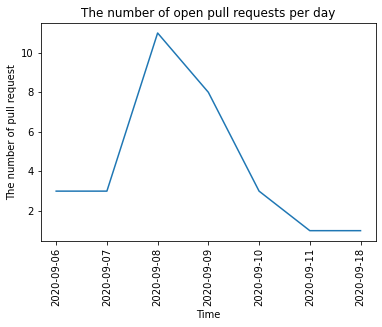

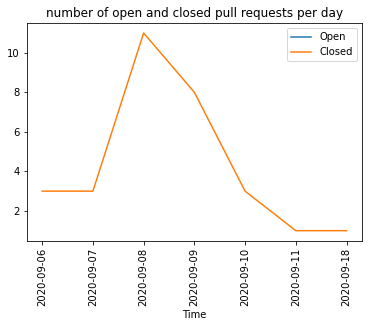

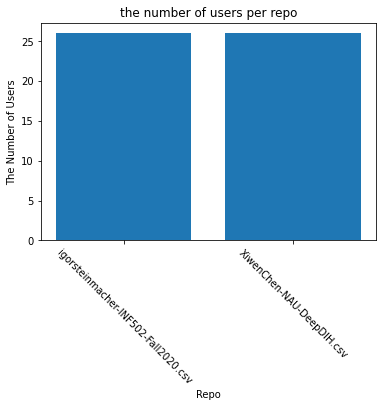

Please Input Your option 1-9:
        1: Collect data from a specific repo.
        2: list all pull requests from a repo.
        3: list the summary of a repo
        4: Graphical summary of a repo
        5: Correlation between the data from a repo 
        6: List all collected repos 
        7: Correlation between the data from users 
        8: Graphical summary of pull requests from all repos
        9: Exit exit.
        Your Input is:4
              name            owner
0  INF502-Fall2020  igorsteinmacher
1          DeepDIH    XiwenChen-NAU
2  INF502-Fall2020  igorsteinmacher
3          DeepDIH    XiwenChen-NAU
4  INF502-Fall2020  igorsteinmacher
5          DeepDIH    XiwenChen-NAU
6          DeepDIH    XiwenChen-NAU
7  INF502-Fall2020  igorsteinmacher
**If a repo has multiple collections, You can only operate the most current collected repo**

please input the index of the repo:7


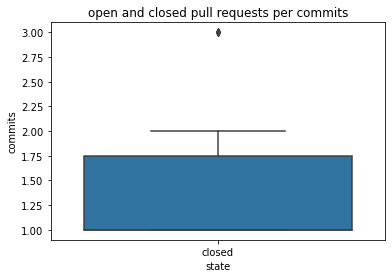

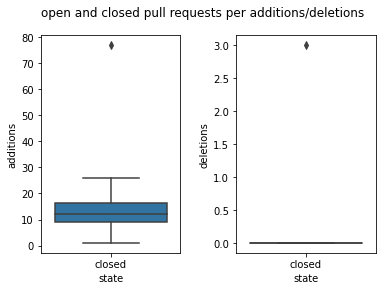

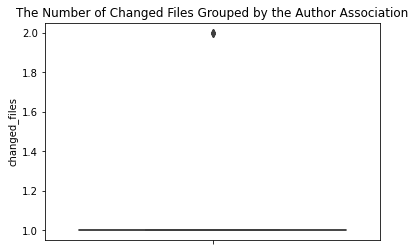

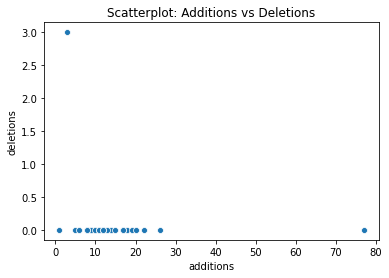

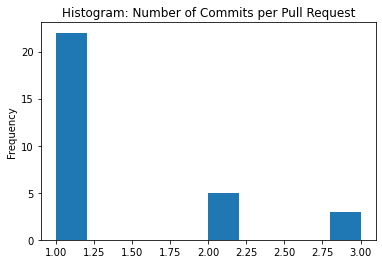

Please Input Your option 1-9:
        1: Collect data from a specific repo.
        2: list all pull requests from a repo.
        3: list the summary of a repo
        4: Graphical summary of a repo
        5: Correlation between the data from a repo 
        6: List all collected repos 
        7: Correlation between the data from users 
        8: Graphical summary of pull requests from all repos
        9: Exit exit.
        Your Input is:4
              name            owner
0  INF502-Fall2020  igorsteinmacher
1          DeepDIH    XiwenChen-NAU
2  INF502-Fall2020  igorsteinmacher
3          DeepDIH    XiwenChen-NAU
4  INF502-Fall2020  igorsteinmacher
5          DeepDIH    XiwenChen-NAU
6          DeepDIH    XiwenChen-NAU
7  INF502-Fall2020  igorsteinmacher
**If a repo has multiple collections, You can only operate the most current collected repo**

please input the index of the repo:1
**No any pull request for current repo**

Please Input Your option 1-9:
        1: Collect data 

,number,commits,additions,deletions,changed_files
number,1.000000,-0.079081,-0.129442,0.311086,NaN
commits,-0.079081,1.000000,-0.189088,0.178887,NaN
additions,-0.129442,-0.189088,1.000000,-0.162779,NaN
deletions,0.311086,0.178887,-0.162779,1.000000,NaN
changed_files,NaN,NaN,NaN,NaN,NaN


Please Input Your option 1-9:
        1: Collect data from a specific repo.
        2: list all pull requests from a repo.
        3: list the summary of a repo
        4: Graphical summary of a repo
        5: Correlation between the data from a repo 
        6: List all collected repos 
        7: Correlation between the data from users 
        8: Graphical summary of pull requests from all repos
        9: Exit exit.
        Your Input is:5
              name            owner
0  INF502-Fall2020  igorsteinmacher
1          DeepDIH    XiwenChen-NAU
2  INF502-Fall2020  igorsteinmacher
3          DeepDIH    XiwenChen-NAU
4  INF502-Fall2020  igorsteinmacher
5          DeepDIH    XiwenChen-NAU
6          DeepDIH    XiwenChen-NAU
7  INF502-Fall2020  igorsteinmacher
**If a repo has multiple collections, You can only operate the most current collected repo**

please input the index of the repo:7


,number,commits,additions,deletions,changed_files
number,1.000000,-0.079081,-0.129442,0.311086,NaN
commits,-0.079081,1.000000,-0.189088,0.178887,NaN
additions,-0.129442,-0.189088,1.000000,-0.162779,NaN
deletions,0.311086,0.178887,-0.162779,1.000000,NaN
changed_files,NaN,NaN,NaN,NaN,NaN


Please Input Your option 1-9:
        1: Collect data from a specific repo.
        2: list all pull requests from a repo.
        3: list the summary of a repo
        4: Graphical summary of a repo
        5: Correlation between the data from a repo 
        6: List all collected repos 
        7: Correlation between the data from users 
        8: Graphical summary of pull requests from all repos
        9: Exit exit.
        Your Input is:7


,#PullReq,#repo,#followers,#following,#contributions
#PullReq,1.000000,0.192928,0.188098,0.357223,0.041052
#repo,0.192928,1.000000,0.625077,0.574689,0.909842
#followers,0.188098,0.625077,1.000000,0.741108,0.572310
#following,0.357223,0.574689,0.741108,1.000000,0.417375
#contributions,0.041052,0.909842,0.572310,0.417375,1.000000


Please Input Your option 1-9:
        1: Collect data from a specific repo.
        2: list all pull requests from a repo.
        3: list the summary of a repo
        4: Graphical summary of a repo
        5: Correlation between the data from a repo 
        6: List all collected repos 
        7: Correlation between the data from users 
        8: Graphical summary of pull requests from all repos
        9: Exit exit.
        Your Input is:9


In [16]:
if __name__ == "__main__":
    main()

example:
- igorsteinmacher
- INF502-Fall2020
- CS499-OSS
- XiwenChen-NAU
- DeepDIH

## Unit Test

In [17]:
class Testing(unittest.TestCase):
    def testUserPath(self):
        Repo("XiwenChen-NAU","DeepDIH")
        self.assertTrue(os.path.exists("users.csv"))
    def testReposPath(self):
        Repo("XiwenChen-NAU","DeepDIH")
        self.assertTrue(os.path.exists("repos.csv"))
    def testRepoFile(self):
        RepoStr = Repo("XiwenChen-NAU","DeepDIH").__str__()
        Target = 'XiwenChen-NAU/DeepDIH: None(2 stars)'
        self.assertEqual(RepoStr,Target)
    def testPullFile(self):
        Repo("igorsteinmacher","INF502-Fall2020")
        Filename = "./repos/"+"igorsteinmacher"+"-"+"INF502-Fall2020"+".csv"
        self.assertTrue(os.path.exists(Filename))
    def testRepoUsers(self):
        self.assertEqual(Repo("igorsteinmacher","INF502-Fall2020").NumOfUsers,26)
        
unittest.main(argv=['first-arg-is-ignored'], exit=False)

.

This repo is collected to .csv file


.

This repo is collected to .csv file


.

This repo is collected to .csv file


.

This repo is collected to .csv file


.

This repo is collected to .csv file



----------------------------------------------------------------------
Ran 5 tests in 100.457s

OK


A=Repo("igorsteinmacher","INF502-Fall2020")